In [15]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import subprocess
import gc
import io
import pandas as pd
import scipy.fftpack
import sys
sys.path.append("/home/brown/python_packages/physiobank")
import physiobank



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

In [38]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [19]:
data_dir, database = physiobank.download_seizure_data()

In [22]:
signal_file = "chb01_03"

In [23]:
environment = os.environ.copy()
environment["WFDB"] = os.path.abspath(data_dir) if "WFDB" not in environment else " ".join((os.path.abspath(data_dir),environment["WFDB"]))
data = subprocess.run(
    ["rdsamp", "-r", database + "/" + signal_file + ".edf", "-c", "-H", "-f", "0", "-v", "-Ps"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    env = environment 
)
data = data.stdout.decode("utf-8")
print(data)
gc.collect()
df_data = pd.read_csv(io.StringIO(data), header=[0,1])
del data
gc.collect()
ann = subprocess.check_output(
    ["rdann", "-r", database + "/" + signal_file + ".edf", "-f", "0", "-a", "seizures", "-v"],
    env = environment
)
print(ann)
df_ann = pd.read_fwf(io.StringIO(ann.decode("utf-8")))
del ann
gc.collect()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



b'      Time       Date     Sample #  Type  Sub Chan  Num\tAux\n[13:43:04.000 06/11/2076]        0     "    0    0    0\t## time resolution: 256\n[13:43:04.000 06/11/2076]        0          0    0    0\n[14:33:00.000 06/11/2076]   766976     [    0    0    0\n[14:33:40.000 06/11/2076]   777216     ]    0    0    0\n'


31

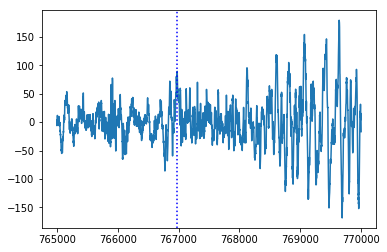

In [27]:
sample = slice(765000,770000)
plt.plot(np.mgrid[sample], df_data.as_matrix()[sample,7])
changes = df_ann["Sample #"].iloc[2:]
for change in changes[:1]:
    plt.axvline(x=change,color='b',ls=":")
plt.show()

In [46]:
def spectrum(sig, d):
    f = scipy.fftpack.rfftfreq(sig.size, d=d)
    y = scipy.fftpack.rfft(sig)
    return f, y

In [47]:
f, y = spectrum(df_data.as_matrix()[:,7], 1/256)

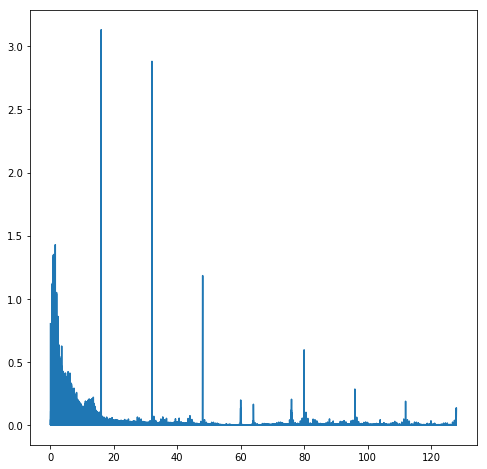

In [53]:
y_a = np.abs(y)/df_data.shape[0]*2 # Scale accordingly
plt.plot(f, y_a)
plt.show()